# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, random, os, warnings, time, ast, sys, pickle, copy, cv2
from tqdm import tqdm
from datetime import datetime
from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchaudio
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms, models


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pandas.core.common import flatten
import albumentations as A
from albumentations.pytorch import ToTensorV2

import librosa
import librosa.display


import warnings
warnings.filterwarnings("ignore")

## GPU usage if available

In [2]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Utils methods provided by FMA Github Repo

In [3]:
# path to the small directory
SMALL_AUDIO_DIR = 'fma_small/fma_small'

# function to get the paths to all the songs in the small dataset
def audio_paths(AUDIO_DIR):
    AUDIO_PATHS = []
    # iterate through all the directories with songs in them
    for path in [os.path.join('fma_small/fma_small', p) 
                 for p in os.listdir('fma_small/fma_small') 
                 if not (p.endswith('checksums') or p.endswith('.txt') or p.endswith('.DS_Store'))]:
        # add all songs to the list
        AUDIO_PATHS = AUDIO_PATHS + [os.path.join(path, track).replace('\\', '/') for track in os.listdir(path)]
    
    return AUDIO_PATHS

# store all the small paths
SMALL_PATHS = audio_paths(SMALL_AUDIO_DIR)
print(len(SMALL_PATHS))

8000


## Three audio files were detected to be corrupted. They are taken out!

In [4]:
SMALL_PATHS.remove('fma_small/fma_small/099/099134.mp3')
SMALL_PATHS.remove('fma_small/fma_small/108/108925.mp3')
SMALL_PATHS.remove('fma_small/fma_small/133/133297.mp3')
print(len(SMALL_PATHS))

7997


In [ ]:
# function to load metadata
# adapted from https://github.com/mdeff/fma/blob/master/utils.py
def metadata_load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    pd.CategoricalDtype(categories=SUBSETS, ordered=True))
        except ValueError:
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks
    
# function to get genre information for each track ID
def track_genre_information(GENRE_PATH, TRACKS_PATH, FILE_PATHS, subset):
    """
    GENRE_PATH (str): path to the csv with the genre metadata
    TRACKS_PATH (str): path to the csv with the track metadata
    FILE_PATHS (list): list of paths to the mp3 files
    subset (str): the subset of the data desired
    """
    # get the genre information
    genres = pd.read_csv(GENRE_PATH)

    # load metadata on all the tracks
    tracks = metadata_load(TRACKS_PATH)

    # focus on the specific subset tracks
    subset_tracks = tracks[tracks['set', 'subset'] <= subset]

    # extract track ID and genre information for each track
    subset_tracks_genre = np.array([np.array(subset_tracks.index), 
                                  np.array(subset_tracks['track', 'genre_top'])]).T
    
    # extract track indices from the file paths
    track_indices = []
    for path in FILE_PATHS:
        track_indices.append(path.split('/')[-1].split('.')[0].lstrip('0'))

    # get the genre associated with each file path, thanks to the path ID
    track_indices = pd.DataFrame({'file_path':FILE_PATHS,'track_id':np.array(track_indices).astype(int)})
    tracks_genre_df = pd.DataFrame({'track_id': subset_tracks_genre[:,0], 'genre': subset_tracks_genre[:,1]})
    track_genre_data = track_indices.merge(tracks_genre_df, how='left')
    
    # label classes with numbers
    encoder = preprocessing.LabelEncoder()
    track_genre_data['genre_nb'] = encoder.fit_transform(track_genre_data.genre)
    
    return track_genre_data

# get genre information for all tracks from the small subset
GENRE_PATH = 'fma_metadata/fma_metadata/genres.csv'
TRACKS_PATH = 'fma_metadata/fma_metadata/tracks.csv'
subset = 'small'

small_tracks_genre = track_genre_information(GENRE_PATH, TRACKS_PATH, SMALL_PATHS, subset)

In [43]:
df = small_tracks_genre.copy()
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["genre_nb"])

#  **EDA & Data Pre-Processing**

Y is a numpy array: [0.         0.         0.         ... 0.00694924 0.00598744 0.        ]
Shape of Y: (660984,)
Sample Rate: 22050


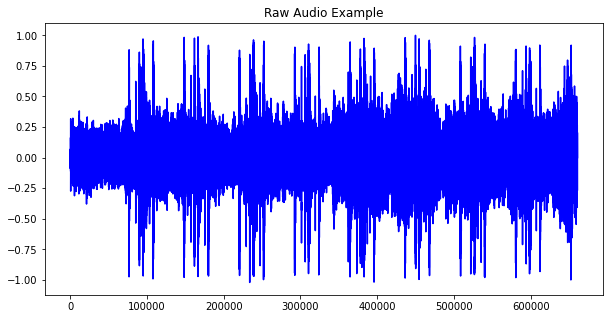

In [8]:
# load the audio file and show raw data and sample rate
y, sr = librosa.load(df['file_path'].iloc[0])
print("Y is a numpy array:", y)
print("Shape of Y:", y.shape)
print("Sample Rate:", sr)
pd.Series(y).plot(figsize=(10,5), title="Raw Audio Example", color='blue');

Shape of Mel Spectogram (256, 1291)


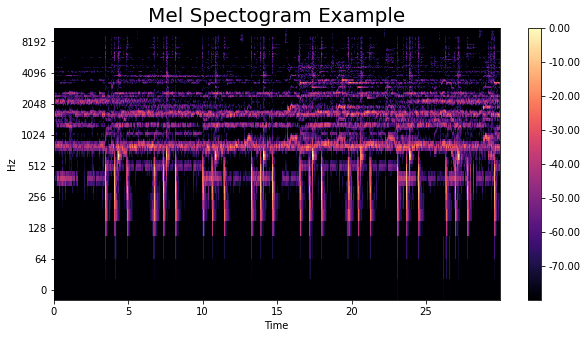

In [13]:
# apply mel spectogram without STFT
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128*2)
print("Shape of Mel Spectogram", S.shape)
# use that converting function as above
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)
# plot the mel spectogram
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

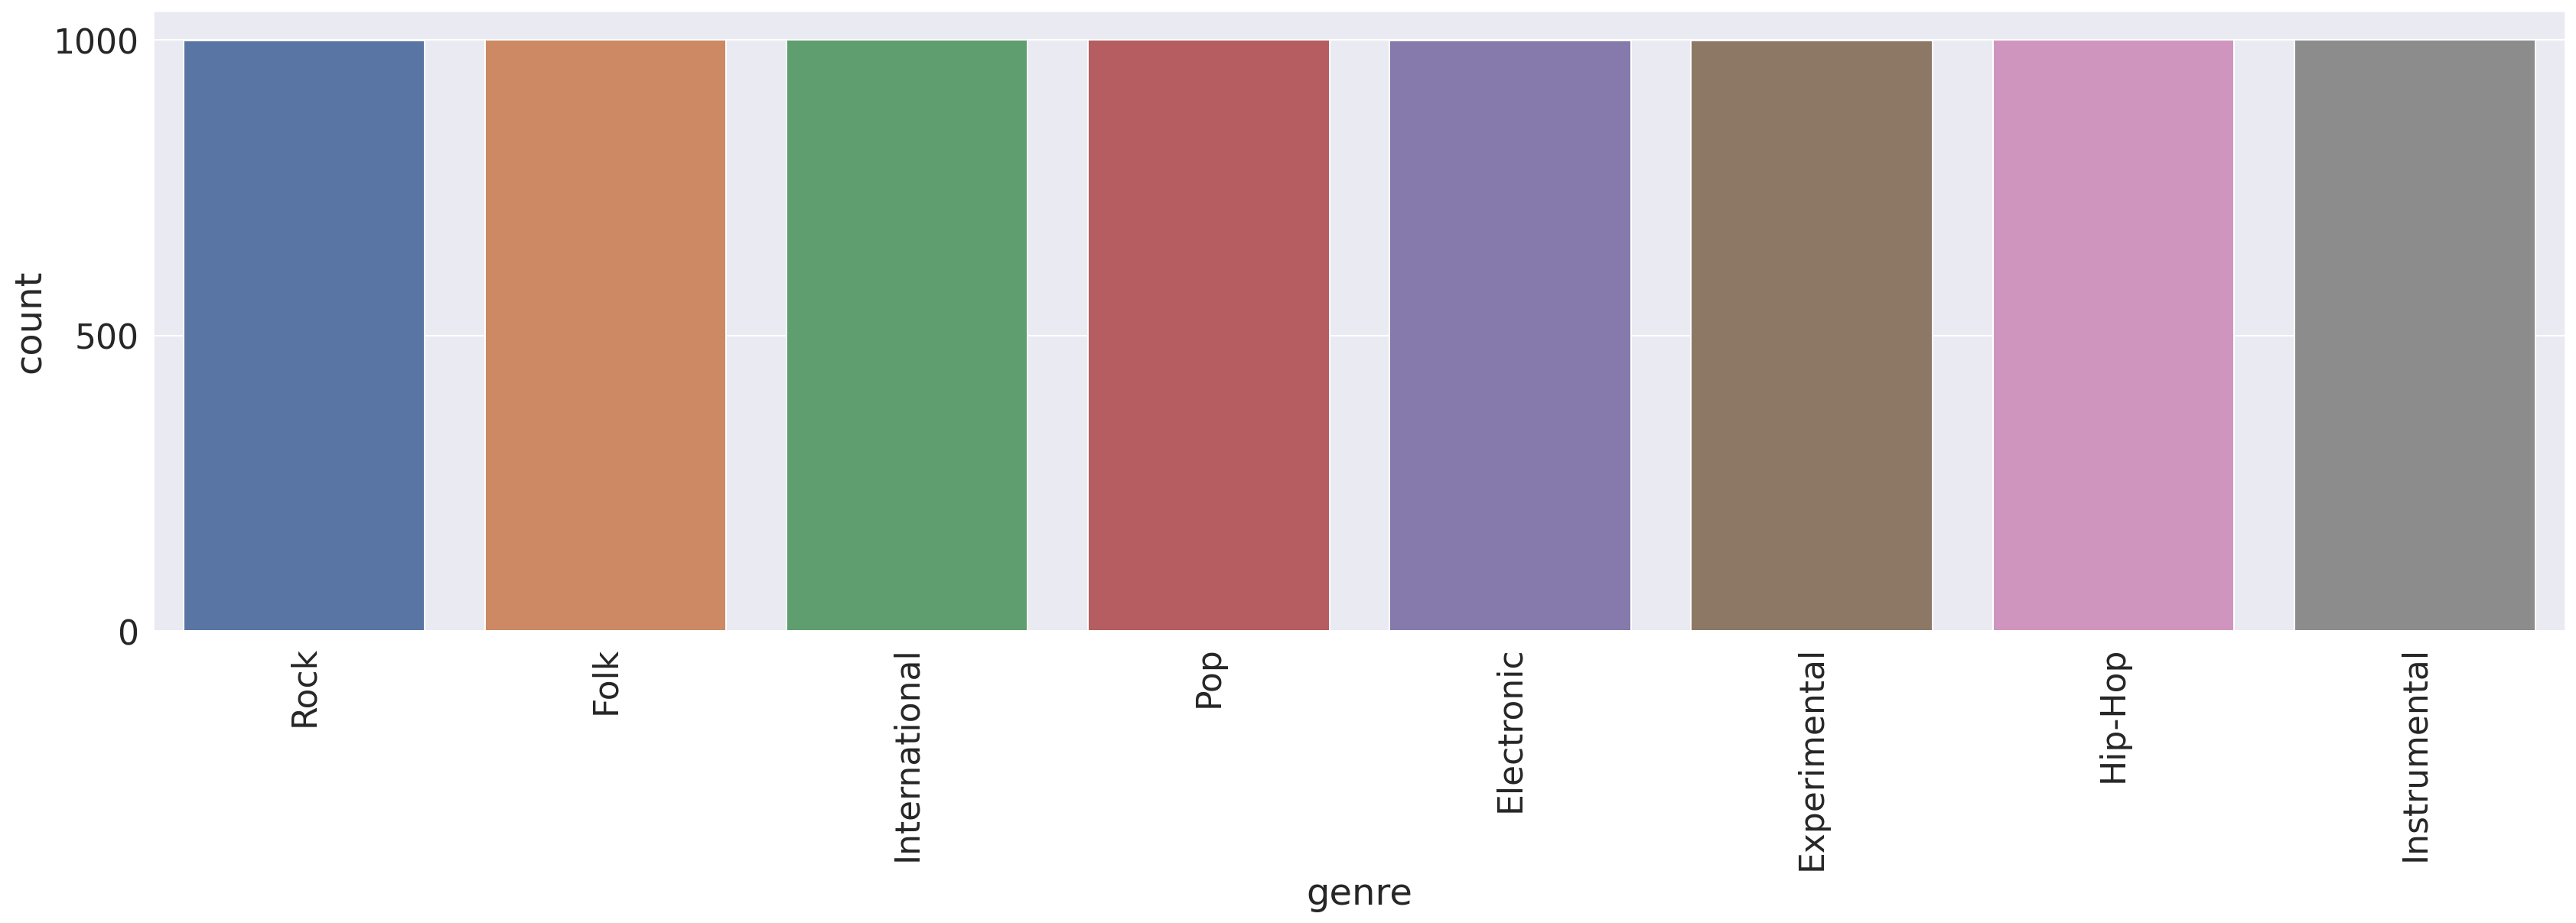

In [23]:
plt.figure(figsize=(25,10))
sns.countplot(x=df.genre) # plot the categories
sns.set(font_scale=5)
plt.xticks(rotation=90);
plt.tight_layout()
plt.savefig('dataset2.png')

# Method 1 - Classification from Raw Audio 
The model is taken from the paper below:

https://arxiv.org/pdf/1610.00087.pdf

## Data Pre-Processing

In [44]:
class ToMono(torch.nn.Module):
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return torch.mean(waveform, dim=0, keepdim=True)

class Normalize(torch.nn.Module):
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return (waveform-waveform.mean()) / waveform.std()

class Pad(torch.nn.Module):
    def __init__(self, value: float, size: int):
        super(Pad, self).__init__()
        self.value = value
        self.size = size
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        return torch.nn.functional.pad(waveform, (0, self.size-max(waveform.shape)), "constant", self.value)

audio_transform = torch.nn.Sequential(*[
    ToMono(), #converts audio channels to mono 
    torchaudio.transforms.Resample(orig_freq=441000, new_freq=8000), # downsamples audio signal to 8000 HZ
    Normalize(), # normalize audio signal to have mean=0 & std=1
    Pad(value=0, size=30000),
])

# Pytorch Dataset

In [45]:
class FMADataset(Dataset):
    def __init__(self, df, transform=None):
        self.transform = transform
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        file_path = self.df.iloc[index]['file_path']
        label = self.df.iloc[index]['genre_nb']
        
        # load the audio file and extract features
        waveform, sample_rate = torchaudio.load(file_path)
        if self.transform:
            waveform = self.transform(waveform) 
        return waveform, label

# Pytorch DataLoader

In [46]:
train_data = FMADataset(train_df, audio_transform)
test_data = FMADataset(test_df, audio_transform)

In [47]:
random_seed= 42
shuffle_dataset = True

# Creating data indices for training and validation splits:
train_indices = list(range(len(train_data)))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)

In [48]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler,num_workers=2 )
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=2)

In [49]:
class CNN(torch.nn.Module):
    def __init__(self, channels, conv_kernels, conv_strides, conv_padding, pool_padding, num_classes=10):
        assert len(conv_kernels) == len(channels) == len(conv_strides) == len(conv_padding)
        super(CNN, self).__init__()
        # create conv blocks
        self.conv_blocks = torch.nn.ModuleList()
        prev_channel = 1
        for i in range(len(channels)):
            # add stacked conv layer
            block = []
            for j, conv_channel in enumerate(channels[i]):
                block.append( torch.nn.Conv1d(in_channels = prev_channel, out_channels = conv_channel, kernel_size = conv_kernels[i], stride = conv_strides[i], padding = conv_padding[i]) )
                prev_channel = conv_channel
                # add batch norm layer
                block.append( torch.nn.BatchNorm1d(prev_channel) )
                # adding ReLU
                block.append( torch.nn.ReLU() )
            self.conv_blocks.append( torch.nn.Sequential(*block) )

        # create pool blocks
        self.pool_blocks = torch.nn.ModuleList()
        for i in range(len(pool_padding)):
            # adding Max Pool (drops dims by a factor of 4)
            self.pool_blocks.append( torch.nn.MaxPool1d(kernel_size = 4, stride = 4, padding = pool_padding[i]) )

        # global pooling
        self.global_pool = torch.nn.AdaptiveAvgPool1d(1)
        self.linear = torch.nn.Linear(prev_channel, num_classes)


    def forward(self, inwav):
        for i in range(len(self.conv_blocks)):
            # apply conv layer
            inwav = self.conv_blocks[i](inwav)
            # apply max_pool
            if i < len(self.pool_blocks): inwav = self.pool_blocks[i](inwav)
        # apply global pooling
        out = self.global_pool(inwav).squeeze()
        out = self.linear(out)
        return out.squeeze()

In [50]:
m18 = CNN(channels = [[64], [64]*4, [128]*4, [256]*4, [512]*4],
          conv_kernels = [80, 3, 3, 3, 3],
          conv_strides = [4, 1, 1, 1, 1],
          conv_padding = [38, 1, 1, 1, 1],
          pool_padding = [0, 0, 0, 2])

In [14]:
def test(model, data_loader, verbose=False):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
#     print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        # Loop over test data.
        for features, target in tqdm(data_loader, total=len(data_loader.batch_sampler), desc="Testing"):
            # Forward pass.
            output = model(features.to(device))
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()
    # Print test accuracy.
    percent = 100. * correct / len(data_loader.sampler)
    if verbose:
        print(f'Test accuracy: {correct} / {len(data_loader.sampler)} ({percent:.0f}%)')
    return percent

In [15]:
def train(model, criterion, data_loader, test_loader, optimizer, num_epochs):
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    accs = []
    # Exponential moving average of the loss.
    ema_loss = None

#     print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
        tick = time.time()
        model.train()
        # Loop over data.
        for batch_idx, (features, target) in tqdm(enumerate(data_loader), total=len(data_loader.batch_sampler), desc="training"):
            # Forward pass.
            output = model(features.to(device))
            loss = criterion(output.to(device), target.to(device))
            # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01
            tock = time.time()
        acc = test(model, test_loader, verbose=True)
        accs.append(acc)
        # Print out progress the end of epoch.
        print('Epoch: {} \tLoss: {:.6f} \t Time taken: {:.6f} seconds'.format(epoch+1, ema_loss, tock-tick),)
        torch.save(model.state_dict(), f'model_{epoch}.ckpt')
        print("Model Saved!")
        if os.path.isfile(f'model_{epoch-1}.ckpt'):
            os.remove(f'model_{epoch-1}.ckpt')
    return accs

In [6]:
# using glorot initialization
def init_weights(m):
    if isinstance(m, torch.nn.Conv1d):
        torch.nn.init.xavier_uniform_(m.weight.data)

In [7]:
model = m18
print("Num Parameters:", sum([p.numel() for p in model.parameters()]))
model.apply(init_weights) 

Num Parameters: 3683786


CNN(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv1d(1, 64, kernel_size=(80,), stride=(4,), padding=(38,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU()
    )
    (2): 

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4) #L2 regularization is added

In [ ]:
num_epochs = 36
accs = train(model, criterion, train_loader, test_loader, optimizer, num_epochs=num_epochs)

## To train this model for 36 epochs took me almost 2 days. However, I see that it didn't improve after 5 epochs. Working with raw audio data was very source-demanding.

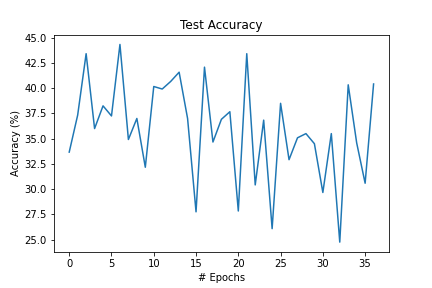

In [13]:
plt.plot(accs)
plt.title("Test Accuracy for m18")
plt.xlabel("# Epochs")
plt.ylabel("Accuracy (%)")
plt.show()

<AxesSubplot:>

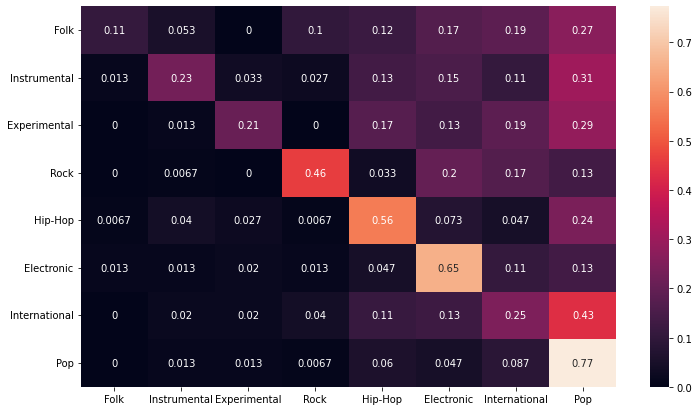

In [57]:
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []
# iterate over test data
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Folk', 'Instrumental', 'Experimental', 'Rock', 'Hip-Hop', 'Electronic', 'International', 'Pop')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

# Method 2 - Mel Spectogram Feature Extraction & Classification

In [ ]:
df = small_tracks_genre.copy()

In [13]:
HOP_LENGTH = 512        # number of samples between successive frames
WINDOW_LENGTH = 512     # length of the window in samples
N_MEL = 128             # number of Mel bands to generate


def compute_melspectrogram_with_fixed_length(audio, sampling_rate, num_of_samples=128):
    try:
        # compute a mel-scaled spectrogram
        melspectrogram = librosa.feature.melspectrogram(y=audio, 
                                                        sr=sampling_rate, 
                                                        hop_length=HOP_LENGTH,
                                                        win_length=WINDOW_LENGTH, 
                                                        n_mels=N_MEL)

        # convert a power spectrogram to decibel units (log-mel spectrogram)
        melspectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
        
        melspectrogram_length = melspectrogram_db.shape[1]
        
        # pad or fix the length of spectrogram 
        if melspectrogram_length != num_of_samples:
            melspectrogram_db = librosa.util.fix_length(melspectrogram_db, 
                                                        size=num_of_samples, 
                                                        axis=1, 
                                                        constant_values=(0, -80.0))
    except Exception as e:
        print("\nError encountered while parsing files\n>>", e)
        return None 
    
    return melspectrogram_db

In [14]:
SOUND_DURATION = 30   # fixed duration of an audio excerpt in seconds

features = []

# iterate through all dataset examples and compute log-mel spectrograms
for index, row in tqdm(df.iterrows(), total=len(df)):
    file_path = df.file_path.iloc[index]
    audio, sample_rate = librosa.load(file_path, duration=SOUND_DURATION, res_type='kaiser_fast')
    
    melspectrogram = compute_melspectrogram_with_fixed_length(audio, sample_rate)
    label = row["genre_nb"]
    
    features.append([melspectrogram, label])

# convert into a Pandas DataFrame 
FMA_df = pd.DataFrame(features, columns=["melspectrogram", "label"])

100%|██████████| 7997/7997 [1:28:59<00:00,  1.50it/s]


Save the features into a pickle file to be used later

In [15]:
"""
# write the Pandas DataFrame object to .pkl file
WRITE_DATA = True

if WRITE_DATA:
  FMA_df.to_pickle("FMA_df.pkl")
"""

In [8]:
FMA_df = pd.read_pickle("FMA_df.pkl")

In [9]:
df2 = FMA_df.copy()
df2

,melspectrogram,label
0,"[[-68.5468, -53.851078, -48.41417, -58.14914, ...",7
1,"[[-80.0, -24.146564, -19.817244, -27.910872, -...",7
2,"[[-80.0, -31.705719, -24.442627, -33.485023, -...",2
3,"[[-80.0, -60.834496, -51.12675, -68.05945, -70...",5
4,"[[-61.365257, -39.28969, -28.805052, -36.32757...",7
...,...,...
7992,"[[-80.0, -51.660835, -30.223862, -27.137949, -...",6
7993,"[[-53.15348, -33.396698, -39.031265, -42.64170...",2
7994,"[[-80.0, -38.456894, -22.686157, -28.588219, -...",6
7995,"[[-80.0, -21.536743, -34.94784, -36.778637, -3...",0


In [10]:
DEFAULT_SAMPLE_RATE = 22050

class FMADataset(Dataset):
    def __init__(self, df2, transform=None):
        assert isinstance(df2, pd.DataFrame)
        assert len(df2.columns) == 2

        self.df2 = df2
        self.transform = transform

    def __len__(self):
        return len(self.df2)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        spectrogram, label = self.df2.iloc[index]

        if self.transform is not None:
            spectrogram = self.transform(spectrogram)

        return {'spectrogram': spectrogram, 'label':label}

## Data Pre-Processing

In [7]:
preds = []
true_labels = []
class Net(nn.Module):
    def __init__(self, device):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=4, padding=0)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=48, out_features=60)
        self.fc2 = nn.Linear(in_features=60, out_features=8)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, eps=1e-07, weight_decay=1e-3)

        self.device = device

    def forward(self, x):
        # cnn layer-1
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=(3,3), stride=3)
        x = F.relu(x)

        # cnn layer-2
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=(2,2), stride=2)
        x = F.relu(x)

        # cnn layer-3
        x = self.conv3(x)
        x = F.relu(x)

        # global average pooling 2D
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x = x.view(-1, 48)

        # dense layer-1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        # dense output layer
        x = self.fc2(x)

        return x
    
    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step() 

                    pbar.update(1)        
            
            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
        return history

    def predict(self, X):
        self.eval()
        
        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)
            
            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1)
            pred, _ = torch.max(outputs,1)
            preds.append(pred)
            true_labels.append(batch['label'])
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)
            
        loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)
        
        return loss, accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

net = Net(device).to(device)
print("Num Parameters:", sum([p.numel() for p in net.parameters()]))
print(net)

cuda:0
Num Parameters: 33512
Net(
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(24, 36, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=48, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=8, bias=True)
  (criterion): CrossEntropyLoss()
)


In [13]:
def init_model():
    # determine if the system supports CUDA
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")

    # init model
    net = Net(device).to(device)
  
    return net

In [14]:
def normalize_data(train_df, test_df):
    # compute the mean and std (pixel-wise)
    mean = train_df['melspectrogram'].mean()
    std = np.std(np.stack(train_df['melspectrogram']), axis=0)

    # normalize train set
    train_spectrograms = (np.stack(train_df['melspectrogram']) - mean) / std
    train_labels = train_df['label'].to_numpy()
    train_df = pd.DataFrame(zip(train_spectrograms, train_labels), columns=['melspectrogram', 'label'])

    # normalize test set
    test_spectrograms = (np.stack(test_df['melspectrogram']) - mean) / std
    test_labels = test_df['label'].to_numpy()
    test_df = pd.DataFrame(zip(test_spectrograms, test_labels), columns=['melspectrogram', 'label'])

    return train_df, test_df

In [15]:
def process_model(dataset_df, epochs=100, batch_size=64, num_of_workers=0):
    # split the data
    train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df["label"])

    # normalize the data
    train_df, test_df = normalize_data(train_df, test_df)

    # init train data loader
    train_ds = FMADataset(train_df, transform=train_transforms)
    train_loader = DataLoader(train_ds, 
                              batch_size=batch_size,
                              shuffle = True,
                              pin_memory=True,
                              num_workers=num_of_workers)
    
    # init test data loader
    test_ds = FMADataset(test_df, transform=test_transforms)
    test_loader = DataLoader(test_ds, 
                            batch_size=batch_size,
                            shuffle = False,
                            pin_memory=True,
                            num_workers=num_of_workers)

    # init model
    model = init_model()

    # pre-training accuracy
    score = model.evaluate(test_loader)
    print("Pre-training accuracy: %.4f%%" % (100 * score[1]))
      
    # train the model
    start_time = datetime.now()
    history = model.fit(train_loader, epochs=epochs, val_loader=test_loader)
    end_time = datetime.now() - start_time
    print("\nTraining completed in time: {}".format(end_time))
      
    return history

In [20]:
def show_results(tot_history):
    """Show accuracy and loss graphs for train and test sets."""

    for i, history in enumerate(tot_history):
        print('\n({})'.format(i+1))

        plt.figure(figsize=(25,10))

        plt.subplot(121)
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.grid(linestyle='--')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')

        plt.subplot(122)
        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.grid(linestyle='--')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig('net_results.png')
        plt.show()

        print('\tMax validation accuracy: %.4f %%' % (np.max(history['val_accuracy']) * 100))
        print('\tMin validation loss: %.5f' % np.min(history['val_loss']))

In [ ]:
history1 = []

print('-'*80)

history = process_model(FMA_df, epochs=500, num_of_workers=4)
history1.append(history)


(1)


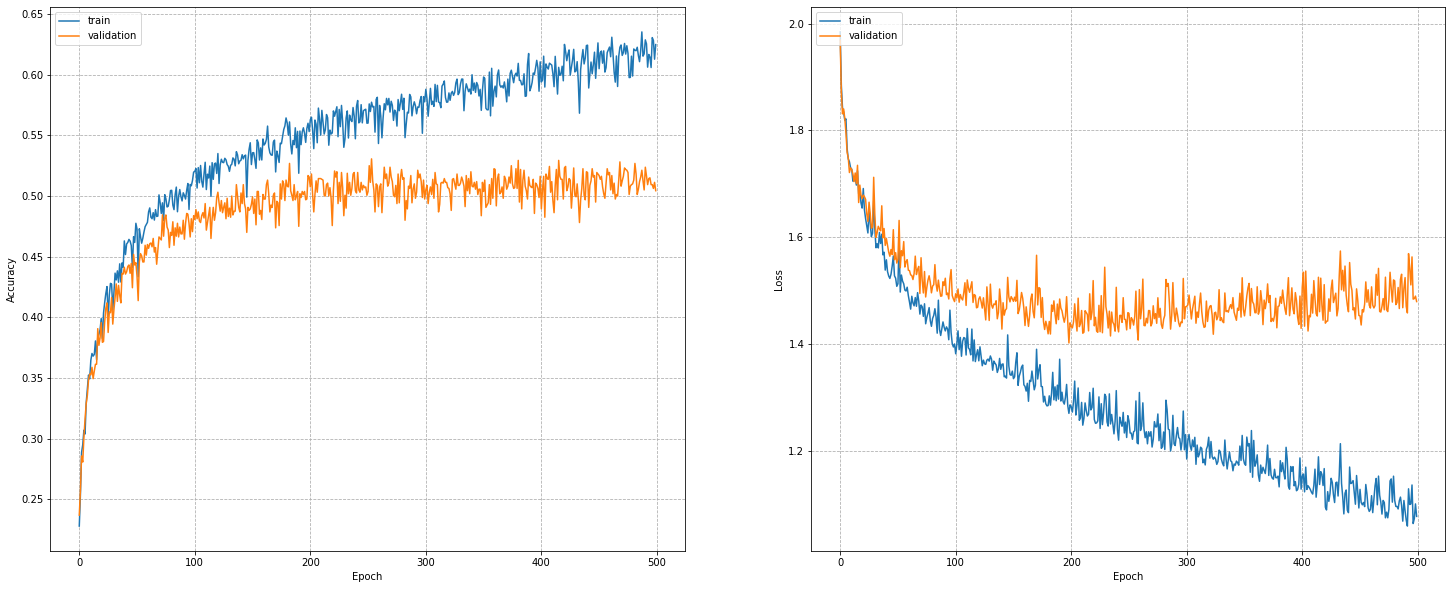

	Max validation accuracy: 53.0625 %
	Min validation loss: 1.40232


In [80]:
show_results(history1)

## Here's an improved version of the model that aims to increase accuracy and prevent overfitting:

The changes made are:

* Increased the number of filters in each convolutional layer to improve feature extraction.
* Added padding of 1 to preserve spatial dimensions and prevent spatial down-sampling.
* Added batch normalization after the third convolutional layer to reduce internal covariate shift and improve training.
* Increased the number of hidden units in the fully connected layers to improve learning capacity.
* Changed the weight decay value to prevent overfitting.

In [8]:
class Net2(nn.Module):

    def __init__(self, device):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, padding=0)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0)

        self.fc1 = nn.Linear(in_features=256, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=8)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001, eps=1e-07, weight_decay=1e-5)

        self.device = device

    def forward(self, x):
        # cnn layer-1
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=(3,3), stride=3)
        x = F.relu(x)

        # cnn layer-2
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=(2,2), stride=2)
        x = F.relu(x)

        # cnn layer-3
        x = self.conv3(x)
        x = F.max_pool2d(x, kernel_size=(2,2), stride=2)
        x = F.relu(x)


        # global average pooling 2D
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        x = x.view(-1, 256)

        # dense layer-1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5)

        # dense output layer
        x = self.fc2(x)

        return x
    
    def fit(self, train_loader, epochs, val_loader=None):
        history = {'loss':[], 'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

        for epoch in range(epochs):
            self.train()

            print("\nEpoch {}/{}".format(epoch+1, epochs))

            with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
                for step, batch in enumerate(train_loader):
                    X_batch = batch['spectrogram'].to(self.device)
                    y_batch = batch['label'].to(self.device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    with torch.set_grad_enabled(True):
                        # forward + backward
                        outputs = self.forward(X_batch)
                        batch_loss = self.criterion(outputs, y_batch)
                        batch_loss.backward()

                        # update the parameters
                        self.optimizer.step() 

                    pbar.update(1)        
            
            # model evaluation - train data
            train_loss, train_acc = self.evaluate(train_loader)
            print("loss: %.4f - accuracy: %.4f" % (train_loss, train_acc), end='')

            # model evaluation - validation data
            val_loss, val_acc = None, None
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader)
                print(" - val_loss: %.4f - val_accuracy: %.4f" % (val_loss, val_acc))

            # store the model's training progress
            history['loss'].append(train_loss)
            history['accuracy'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            
        return history

    def predict(self, X):
        self.eval()
        
        with torch.no_grad():
            outputs = self.forward(X)

        return outputs

    def evaluate(self, data_loader):
        running_loss = torch.tensor(0.0).to(self.device)
        running_acc = torch.tensor(0.0).to(self.device)

        batch_size = torch.tensor(data_loader.batch_size).to(self.device)

        for step, batch in enumerate(data_loader):
            X_batch = batch['spectrogram'].to(self.device)
            y_batch = batch['label'].to(self.device)
            
            outputs = self.predict(X_batch)

            # get batch loss
            loss = self.criterion(outputs, y_batch)
            running_loss = running_loss + loss

            # calculate batch accuracy
            predictions = torch.argmax(outputs, dim=1) 
            correct_predictions = (predictions == y_batch).float().sum()
            running_acc = running_acc + torch.div(correct_predictions, batch_size)
            
        loss = running_loss.item() / (step+1)
        accuracy = running_acc.item() / (step+1)
        
        return loss, accuracy


# determine if the system supports CUDA
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

net = Net2(device).to(device)
print("Num Parameters:", sum([p.numel() for p in net.parameters()]))
print(net)

cuda:0
Num Parameters: 563720
Net2(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
  (criterion): CrossEntropyLoss()
)


In [17]:
def init_model2():
    # determine if the system supports CUDA
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        device = torch.device("cpu")

    # init model
    net = Net2(device).to(device)
  
    return net


def process_model2(dataset_df, epochs=100, batch_size=64, num_of_workers=0):
    # split the data
    train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42, stratify=dataset_df["label"])

    # normalize the data
    train_df, test_df = normalize_data(train_df, test_df)

    # init train data loader
    train_ds = FMADataset(train_df, transform=train_transforms)
    train_loader = DataLoader(train_ds, 
                              batch_size=batch_size,
                              shuffle = True,
                              pin_memory=True,
                              num_workers=num_of_workers)
    
    # init test data loader
    test_ds = FMADataset(test_df, transform=test_transforms)
    test_loader = DataLoader(test_ds, 
                            batch_size=batch_size,
                            shuffle = False,
                            pin_memory=True,
                            num_workers=num_of_workers)

    # init model
    model = init_model2()

    # pre-training accuracy
    score = model.evaluate(test_loader)
    print("Pre-training accuracy: %.4f%%" % (100 * score[1]))
      
    # train the model
    start_time = datetime.now()
    history = model.fit(train_loader, epochs=epochs, val_loader=test_loader)
    end_time = datetime.now() - start_time
    print("\nTraining completed in time: {}".format(end_time))
      
    return history

In [ ]:
history2 = []

print('-'*80)

history = process_model2(FMA_df, epochs=500, num_of_workers=4)
history2.append(history)

### Unlike the expectation, the model accuracy almost stayed the same! It overfitted after ~150 epochs


(1)


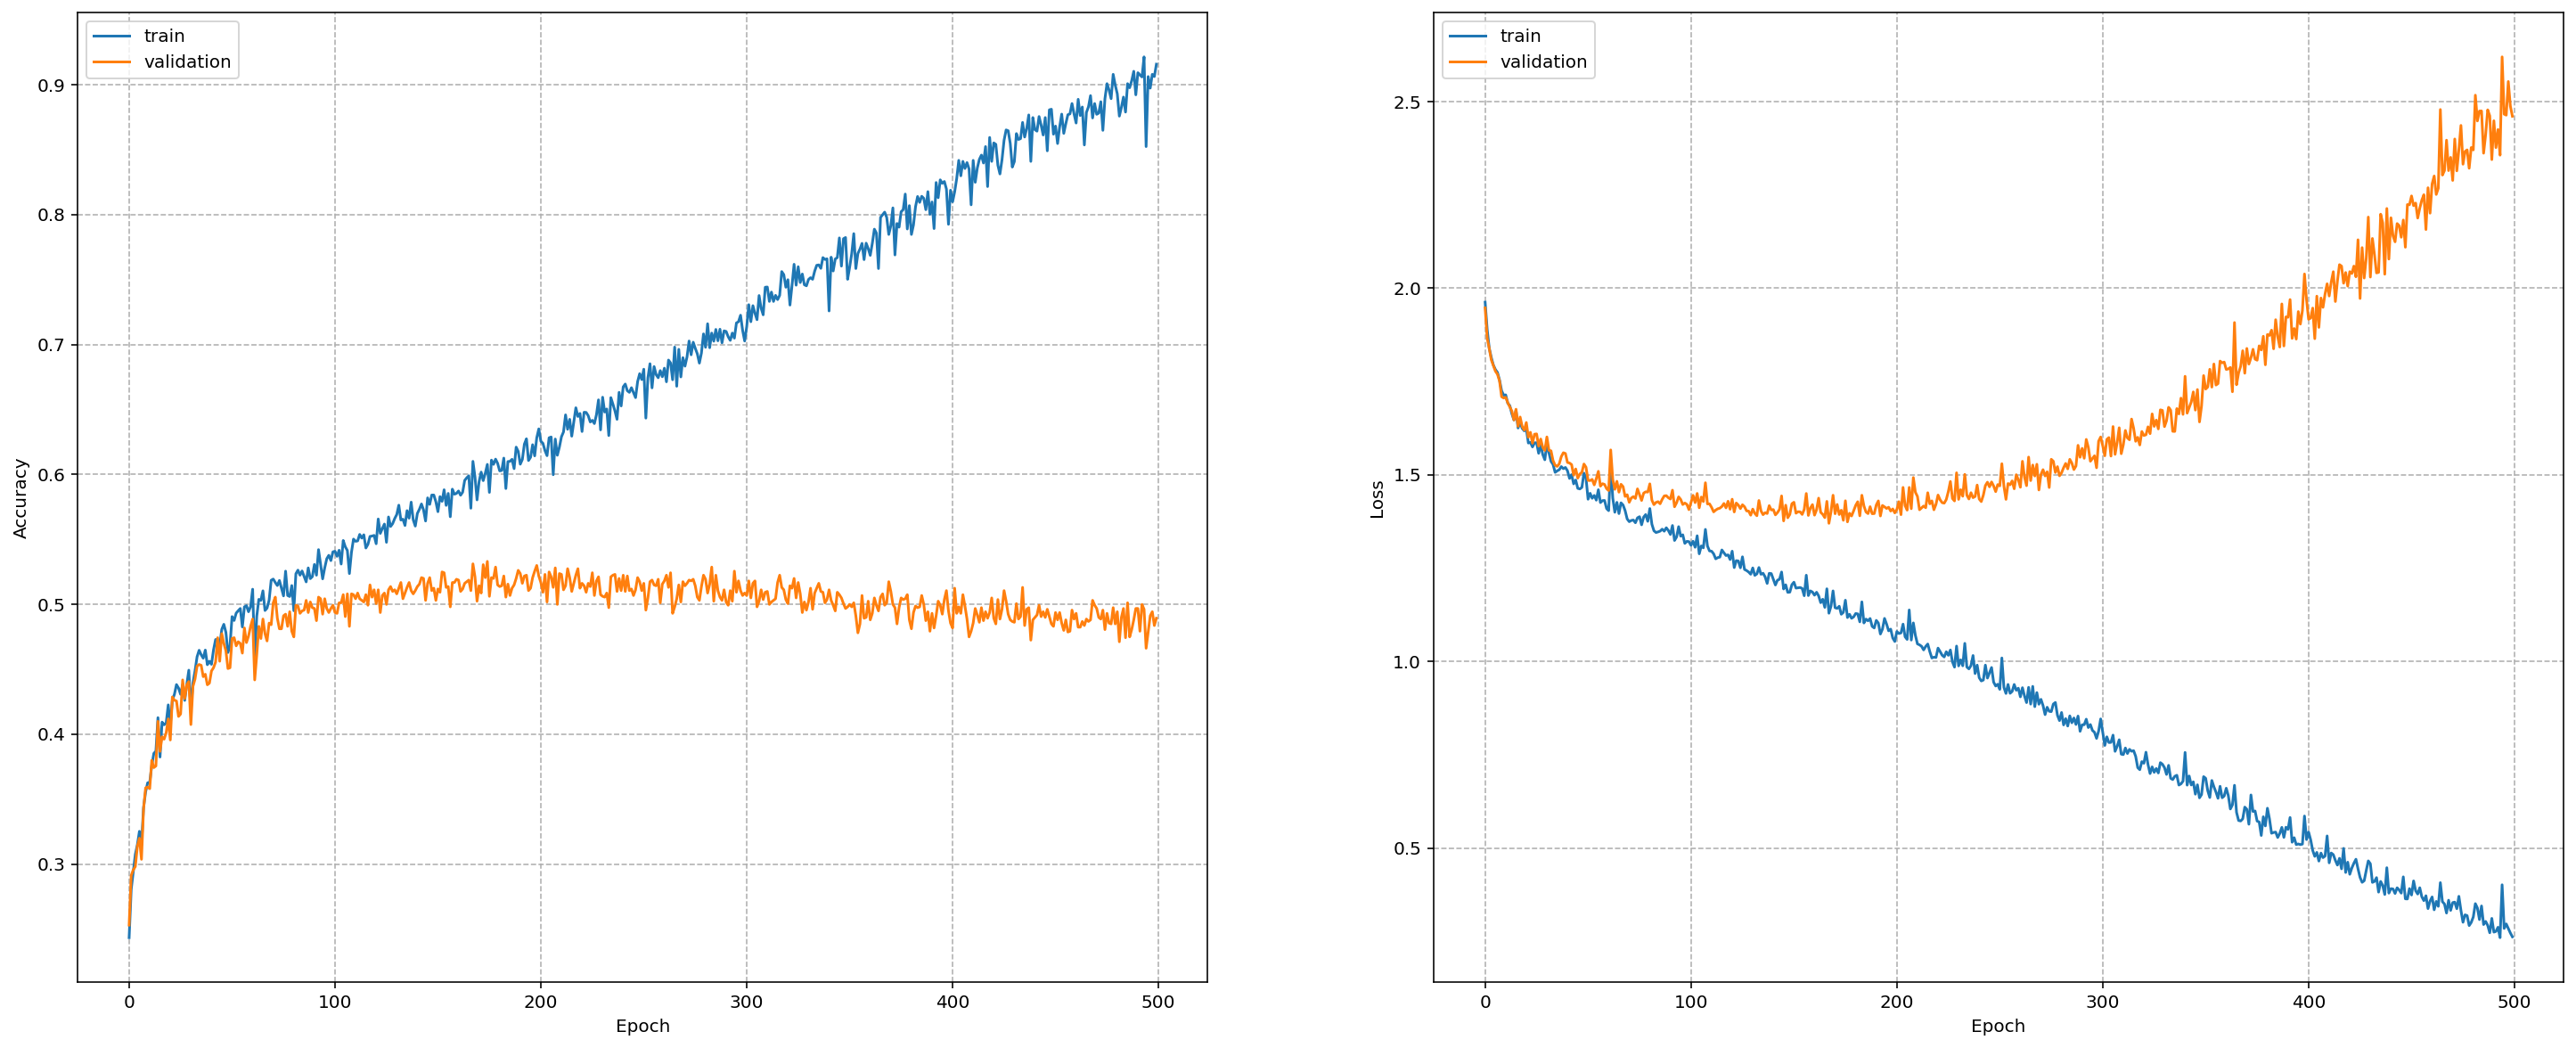

	Max validation accuracy: 53.3125 %
	Min validation loss: 1.36994


In [24]:
tot_history = history2

for i, history in enumerate(tot_history):
    print('\n({})'.format(i+1))

    plt.figure(figsize=(25,10))

    plt.subplot(121)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.grid(linestyle='--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.grid(linestyle='--')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('net_results_2.png')
    plt.show()

    print('\tMax validation accuracy: %.4f %%' % (np.max(history['val_accuracy']) * 100))
    print('\tMin validation loss: %.5f' % np.min(history['val_loss']))

# Method 3 - Image Classification from STFT Images

In [4]:
TRAIN_PATH = '/train'
TEST_PATH = '/test'

train_ds = ImageFolder(TRAIN_PATH, transform=transform)
test_ds = ImageFolder(TEST_PATH, transform=transform)

In [5]:
image, label = train_ds[0]
print(f"Image Size: {image.shape}")
print(f"Label: {label}")
print(image)

Image Size: torch.Size([3, 224, 224])
Label: 0
tensor([[[ 0.1426,  0.0569,  0.3823,  ...,  0.2624, -0.8335, -0.5767],
         [-0.1143, -0.2342,  0.1083,  ...,  0.3652, -0.5424, -0.4397],
         [ 0.2453, -0.0629,  0.1768,  ...,  0.6563, -0.6794, -0.7308],
         ...,
         [-0.1143, -0.0116,  1.4440,  ...,  1.7009,  1.0844, -0.2513],
         [-0.1143, -0.0116,  1.4440,  ...,  1.6838,  1.0844, -0.2513],
         [-0.0972, -0.0458,  0.6734,  ...,  0.7933,  0.5022, -0.1486]],

        [[-1.3704, -1.4055, -1.2829,  ..., -1.3354, -1.6506, -1.5630],
         [-1.4755, -1.4930, -1.3704,  ..., -1.3004, -1.5805, -1.5280],
         [-1.3354, -1.4580, -1.3529,  ..., -1.1954, -1.5805, -1.5630],
         ...,
         [-1.4755, -1.4230, -0.7402,  ..., -0.7227, -1.0203, -1.4580],
         [-1.4755, -1.4230, -0.7402,  ..., -0.7227, -1.0203, -1.4580],
         [-0.6877, -0.6702, -0.3375,  ..., -0.3200, -0.4776, -0.6877]],

        [[ 0.3916,  0.3916,  0.3568,  ...,  0.3916, -0.0092, -0.2707]

In [6]:
classes = train_ds.classes

In [ ]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, pin_memory=True, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True, pin_memory=True, num_workers=8)

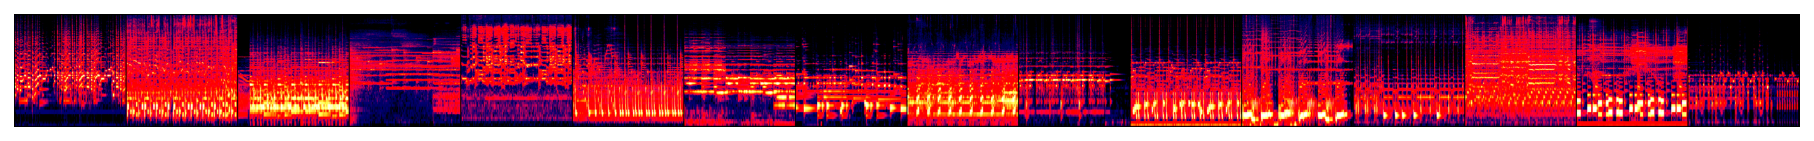

In [8]:
from torchvision.utils import make_grid
for batch in train_dl:
    plt.figure(figsize=(16, 8))
    image, _ = batch
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

In [9]:
"""
Below is a ResNet18 architecture:
There are 4 convolutional layers in each module (excluding the 1×1 convolutional layer). 
Together with the first 7×7 convolutional layer and the final fully-connected layer, there are 
18 layers in total. Therefore, this model is a ResNet-18.
"""

class Residual(nn.Module):
    def __init__(self, in_channel, out_channel, use_1x1Conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=strides)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)

        if use_1x1Conv:
            self.conv3 = nn.Conv2d(in_channel, out_channel, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

    def forward(self, X):
        out = F.relu(self.bn1(self.conv1(X)))
        out = self.bn2(self.conv2(out))
        if self.conv3:
            X = self.conv3(X)
        out += X
        return F.relu(out)

def residualBlock(in_channel, out_channel, num_residuals, first_block=False):
    blks = []
    for i in range(num_residuals):
        if i==0 and not first_block:
            blks.append(Residual(in_channel, out_channel, use_1x1Conv=True,
            strides=2))
        else:
            blks.append(Residual(out_channel, out_channel))
    
    return blks

class ResNet(nn.Module):
    def __init__(self, input_channel, n_classes):
        super().__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(input_channel, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.b2 = nn.Sequential(*residualBlock(64, 64, 2, first_block=True))
        self.b3 = nn.Sequential(*residualBlock(64, 128, 2))
        self.b4 = nn.Sequential(*residualBlock(128, 256, 2))
        self.b5 = nn.Sequential(*residualBlock(256, 512, 2))
        self.finalLayer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),nn.Linear(512, n_classes))

        self.b1.apply(self.init_weights)
        self.b2.apply(self.init_weights)
        self.b3.apply(self.init_weights)
        self.b4.apply(self.init_weights)
        self.b5.apply(self.init_weights)
        self.finalLayer.apply(self.init_weights)

    def init_weights(self, layer):
        if type(layer) == nn.Conv2d:
            nn.init.kaiming_normal_(layer.weight, mode='fan_out')
        if type(layer) == nn.Linear:
            nn.init.normal_(layer.weight, std=1e-3)
        if type(layer) == nn.BatchNorm2d:
            nn.init.constant_(layer.weight, 1)
            nn.init.constant_(layer.bias, 0)
        


    def forward(self, X):
        out = self.b1(X)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.finalLayer(out)

        return out

In [ ]:
input_channel = next(iter(train_dl))[0].shape[1]
input_channel

In [13]:
model = ResNet(input_channel=input_channel, n_classes=8).to(device)
print("Num Parameters:", sum([p.numel() for p in model.parameters()]))
model

Num Parameters: 11183624


ResNet(
  (b1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05

In [10]:
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item()/len(pred))

def validation_step(valid_dl, model, loss_fn):
    for image, label in valid_dl:
        out = model(image)
        loss = loss_fn(out, label)
        acc = accuracy(out, label)
        return {"val_loss": loss, "val_acc": acc}

def fit(train_dl, valid_dl, epochs, optimizer, loss_fn, model):
    history = []
    for epoch in range(epochs):
        for image, label in train_dl:
            out = model(image)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        val = validation_step(valid_dl, model, loss_fn)
        print(f"Epoch [{epoch}/{epochs}] => loss: {loss}, val_loss: {val['val_loss']}, val_acc: {val['val_acc']}")
        history.append({"loss": loss, 
                        "val_loss": val['val_loss'], 
                        "val_acc": val['val_acc']
                       })
    return history

In [11]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

In [ ]:
device='cuda'
model = model.to(device)
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

## This was the most epochs I could go due to limitations of memory. I believe the accuracy will increase as the model is trained on more epochs!

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
history = fit(train_dl, test_dl, epochs, optimizer, loss_fn, model)

Epoch [0/10] => loss: 1.6934446096420288, val_loss: 1.6016418933868408, val_acc: 0.3125
Epoch [1/10] => loss: 1.7410794496536255, val_loss: 1.6093868017196655, val_acc: 0.5
Epoch [2/10] => loss: 1.7889643907546997, val_loss: 2.0496230125427246, val_acc: 0.125
Epoch [3/10] => loss: 1.533724308013916, val_loss: 1.3695672750473022, val_acc: 0.5625
Epoch [4/10] => loss: 1.9376038312911987, val_loss: 1.1598799228668213, val_acc: 0.625
Epoch [5/10] => loss: 1.6645992994308472, val_loss: 1.5779441595077515, val_acc: 0.4375
Epoch [6/10] => loss: 1.2554891109466553, val_loss: 1.2282520532608032, val_acc: 0.5625
Epoch [7/10] => loss: 1.5516115427017212, val_loss: 1.5167149305343628, val_acc: 0.4375
Epoch [8/10] => loss: 1.3168131113052368, val_loss: 1.1594469547271729, val_acc: 0.6875
Epoch [9/10] => loss: 0.9935020804405212, val_loss: 1.6139479875564575, val_acc: 0.4375


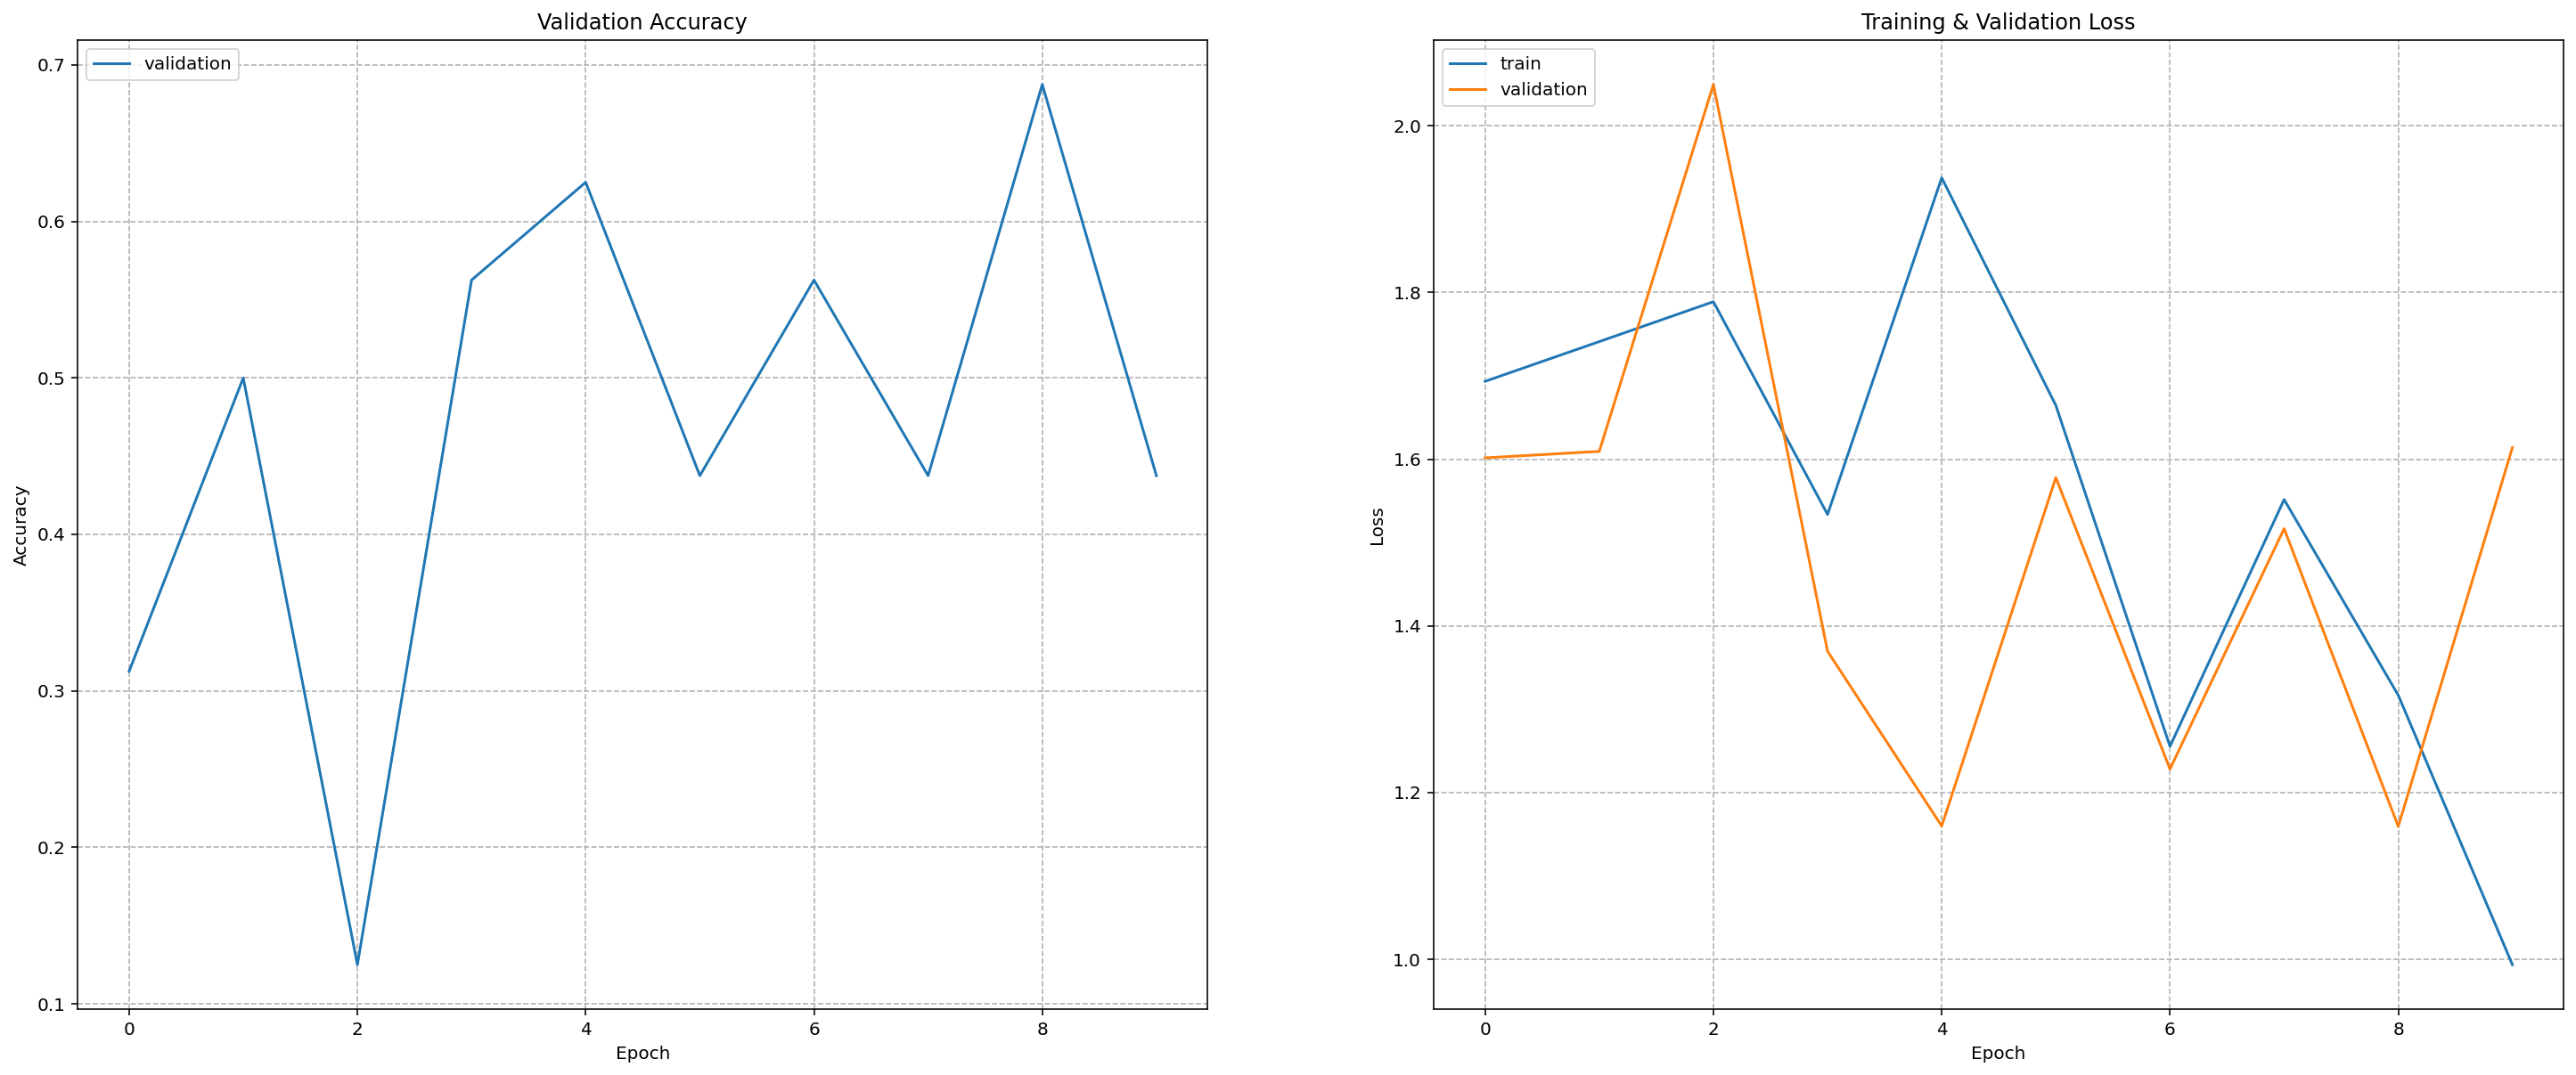

In [34]:
"""Show accuracy and loss graphs for train and test sets."""
train_loss = [x['loss'] for x in history]
val_loss = [x['val_loss'] for x in history]
val_acc = [x['val_acc'] for x in history]
train_loss = [x.item() for x in train_loss]
val_loss = [x.item() for x in val_loss]
val_acc = [x.item() for x in val_acc]

plt.figure(figsize=(25,10))

plt.subplot(121)
plt.plot(val_acc)
plt.grid(linestyle='--')
plt.title('Validation Accuracy');
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['validation'], loc='upper left')

plt.subplot(122)
plt.plot(train_loss)
plt.plot(val_loss)
plt.grid(linestyle='--')
plt.title('Training & Validation Loss');
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('net_results.png')
plt.show()

## Let's apply some transformation techniques before training to see if it increases the accuracy

In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
            transforms.Resize((256, 256)),
            transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.RandomCrop(size=(224, 224)),
            transforms.RandomHorizontalFlip(), 
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [5]:
from torchvision.datasets import ImageFolder

TRAIN_PATH = '/train'
TEST_PATH = '/test'

train_ds = ImageFolder(TRAIN_PATH, transform=transform)
test_ds = ImageFolder(TEST_PATH, transform=transform)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, pin_memory=True, num_workers=8)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=True, pin_memory=True, num_workers=8)

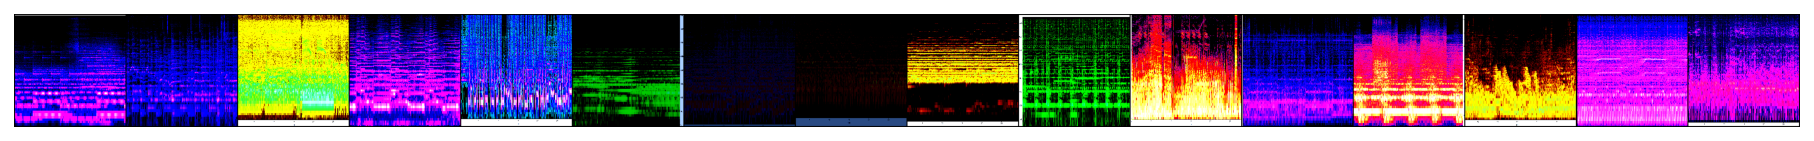

In [9]:
from torchvision.utils import make_grid
for batch in train_dl:
    plt.figure(figsize=(16, 8))
    image, _ = batch
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break

In [10]:
model = ResNet(input_channel=input_channel, n_classes=8).to(device)

In [13]:
device='cuda'
model = model.to(device)
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
history2 = fit(train_dl, test_dl, epochs, optimizer, loss_fn, model)

Epoch [0/10] => loss: 2.0375027656555176, val_loss: 2.075674295425415, val_acc: 0.1875
Epoch [1/10] => loss: 1.8785326480865479, val_loss: 1.6518394947052002, val_acc: 0.5625
Epoch [2/10] => loss: 2.0548532009124756, val_loss: 1.7761908769607544, val_acc: 0.1875
Epoch [3/10] => loss: 1.7500243186950684, val_loss: 2.144927978515625, val_acc: 0.1875
Epoch [4/10] => loss: 1.9592963457107544, val_loss: 2.134664535522461, val_acc: 0.1875
Epoch [5/10] => loss: 1.9414016008377075, val_loss: 1.3909125328063965, val_acc: 0.4375
Epoch [6/10] => loss: 1.8057993650436401, val_loss: 2.0353331565856934, val_acc: 0.1875
Epoch [7/10] => loss: 1.4824841022491455, val_loss: 1.851017713546753, val_acc: 0.3125
Epoch [8/10] => loss: 1.569535732269287, val_loss: 1.786911129951477, val_acc: 0.25
Epoch [9/10] => loss: 1.8326048851013184, val_loss: 1.7127043008804321, val_acc: 0.375


## Contrary to what I was expecting, it hindered the training process immensely!

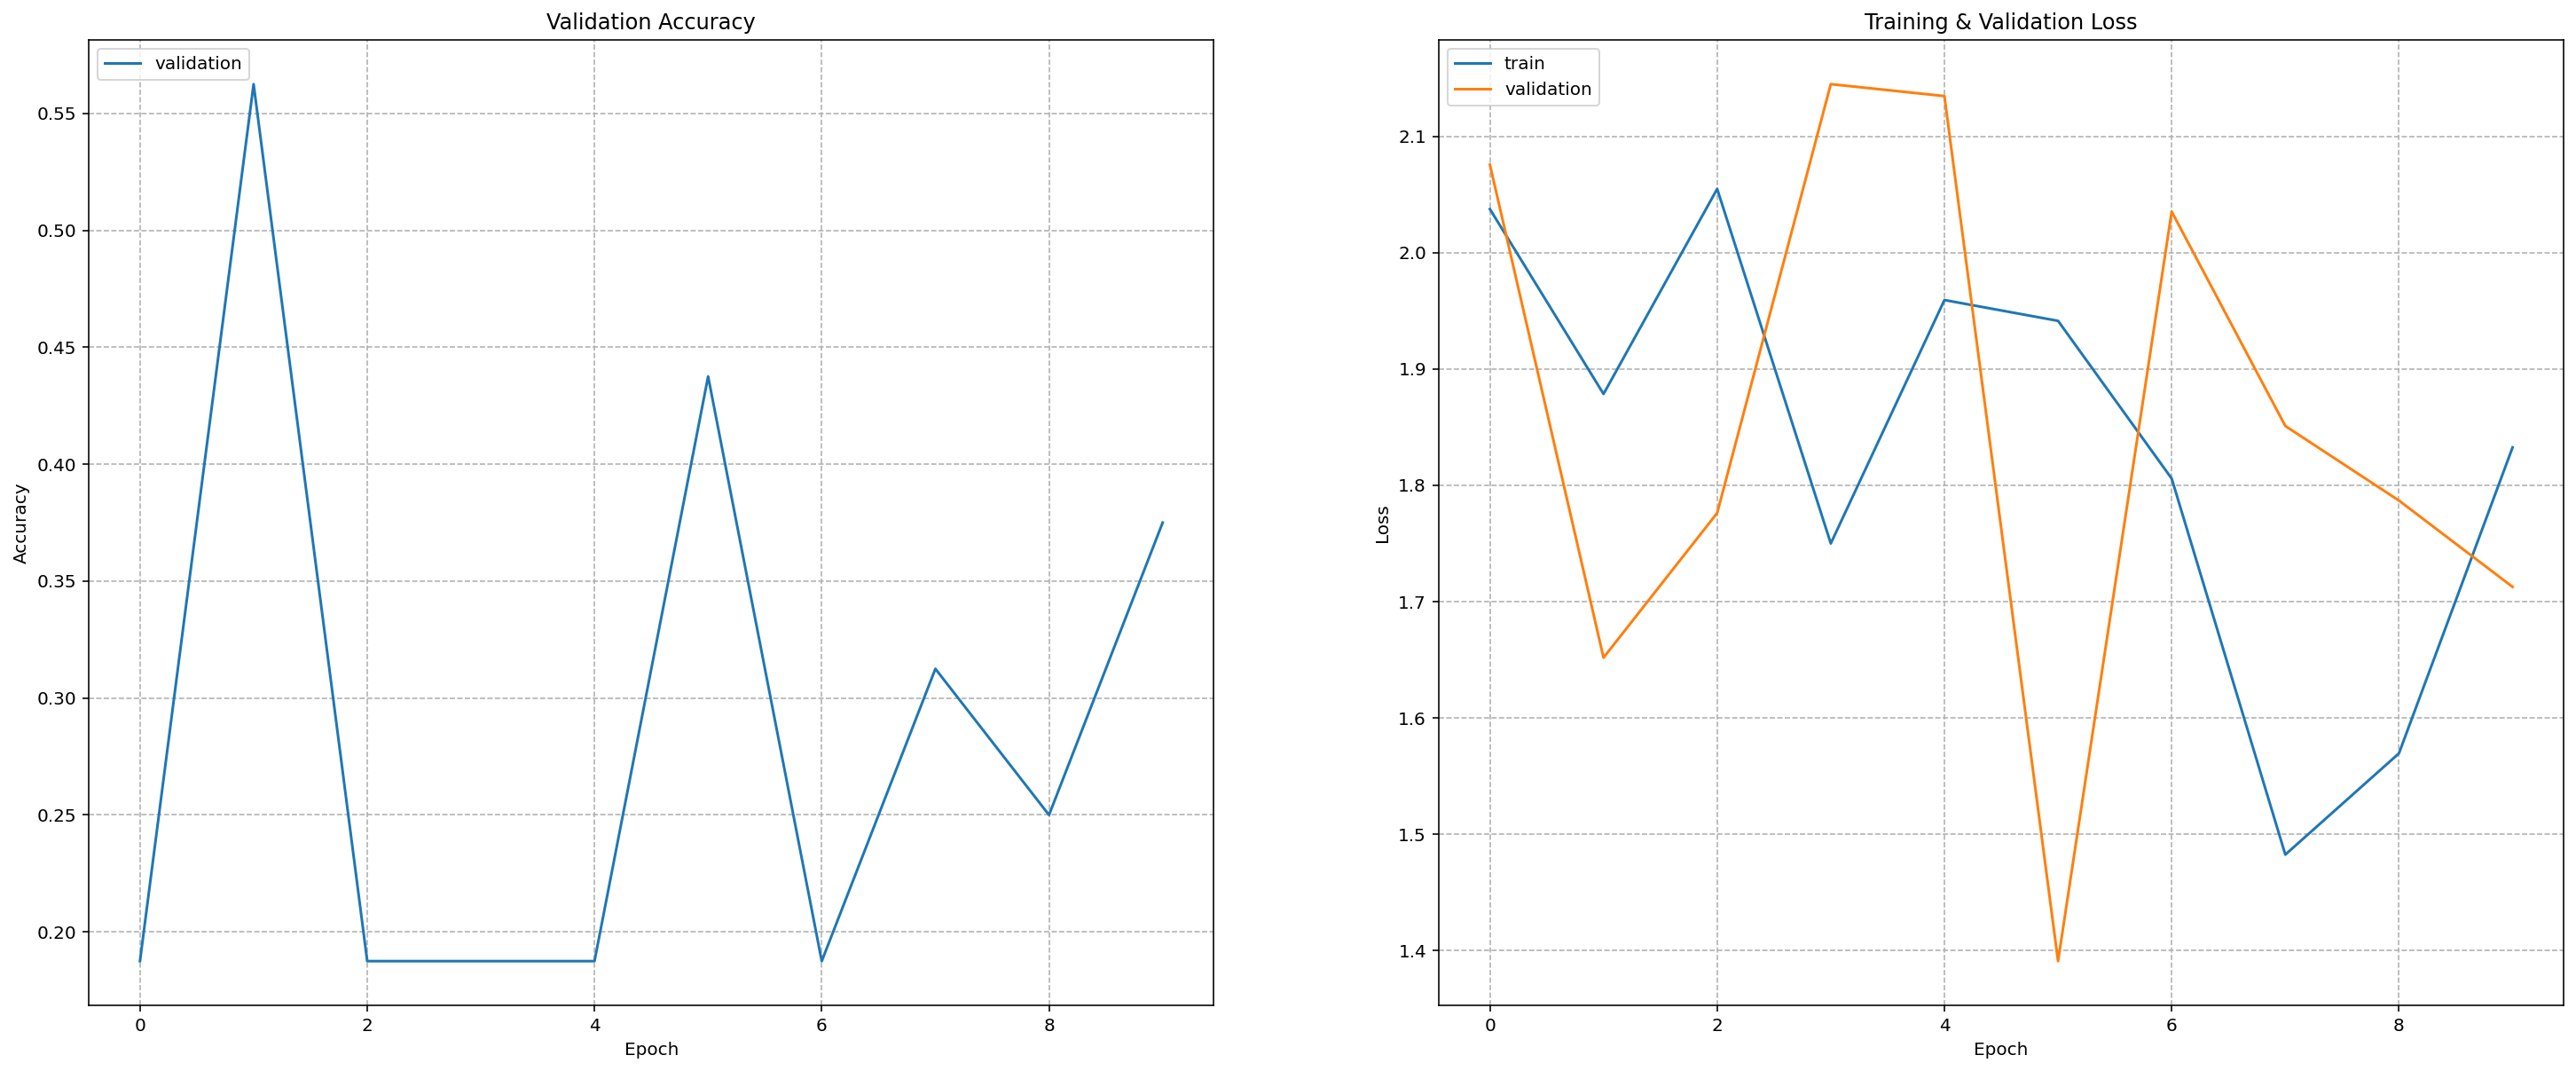

In [17]:
history = history2
"""Show accuracy and loss graphs for train and test sets."""
train_loss = [x['loss'] for x in history]
val_loss = [x['val_loss'] for x in history]
val_acc = [x['val_acc'] for x in history]
train_loss = [x.item() for x in train_loss]
val_loss = [x.item() for x in val_loss]
val_acc = [x.item() for x in val_acc]

plt.figure(figsize=(25,10))

plt.subplot(121)
plt.plot(val_acc)
plt.grid(linestyle='--')
plt.title('Validation Accuracy');
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['validation'], loc='upper left')

plt.subplot(122)
plt.plot(train_loss)
plt.plot(val_loss)
plt.grid(linestyle='--')
plt.title('Training & Validation Loss');
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('net_results.png')
plt.show()

# (Optional) Method 4 - Transfer Learning

In this section, I want to see the effect of pre-trained models.

In [17]:
from torchvision.models import resnet34
model = resnet34(pretrained=True)
model.fc = nn.Linear(512,8)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model = model.to(device)

In [18]:
device='cuda'
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10
history3 = fit(train_dl, test_dl, epochs, optimizer, loss_fn, model)

Epoch [0/10] => loss: 1.5140392780303955, val_loss: 1.5494649410247803, val_acc: 0.4375
Epoch [1/10] => loss: 1.4601695537567139, val_loss: 1.2334933280944824, val_acc: 0.625
Epoch [2/10] => loss: 1.3516649007797241, val_loss: 1.1094064712524414, val_acc: 0.625
Epoch [3/10] => loss: 1.5407551527023315, val_loss: 1.0453174114227295, val_acc: 0.75
Epoch [4/10] => loss: 1.0491191148757935, val_loss: 1.8834203481674194, val_acc: 0.375
Epoch [5/10] => loss: 1.0727016925811768, val_loss: 0.9689133167266846, val_acc: 0.75
Epoch [6/10] => loss: 1.6802937984466553, val_loss: 1.7443852424621582, val_acc: 0.375
Epoch [7/10] => loss: 1.401407241821289, val_loss: 1.037091851234436, val_acc: 0.5
Epoch [8/10] => loss: 0.5224744081497192, val_loss: 0.9240795373916626, val_acc: 0.6875
Epoch [9/10] => loss: 0.4649001657962799, val_loss: 2.4193084239959717, val_acc: 0.375


## Again due to memory limitations, I could train the model for only 10 epochs. It's seen that at some epochs it outperformed previous methods. I believe that for longer epochs, it will surpass other from scracth methods as expected.

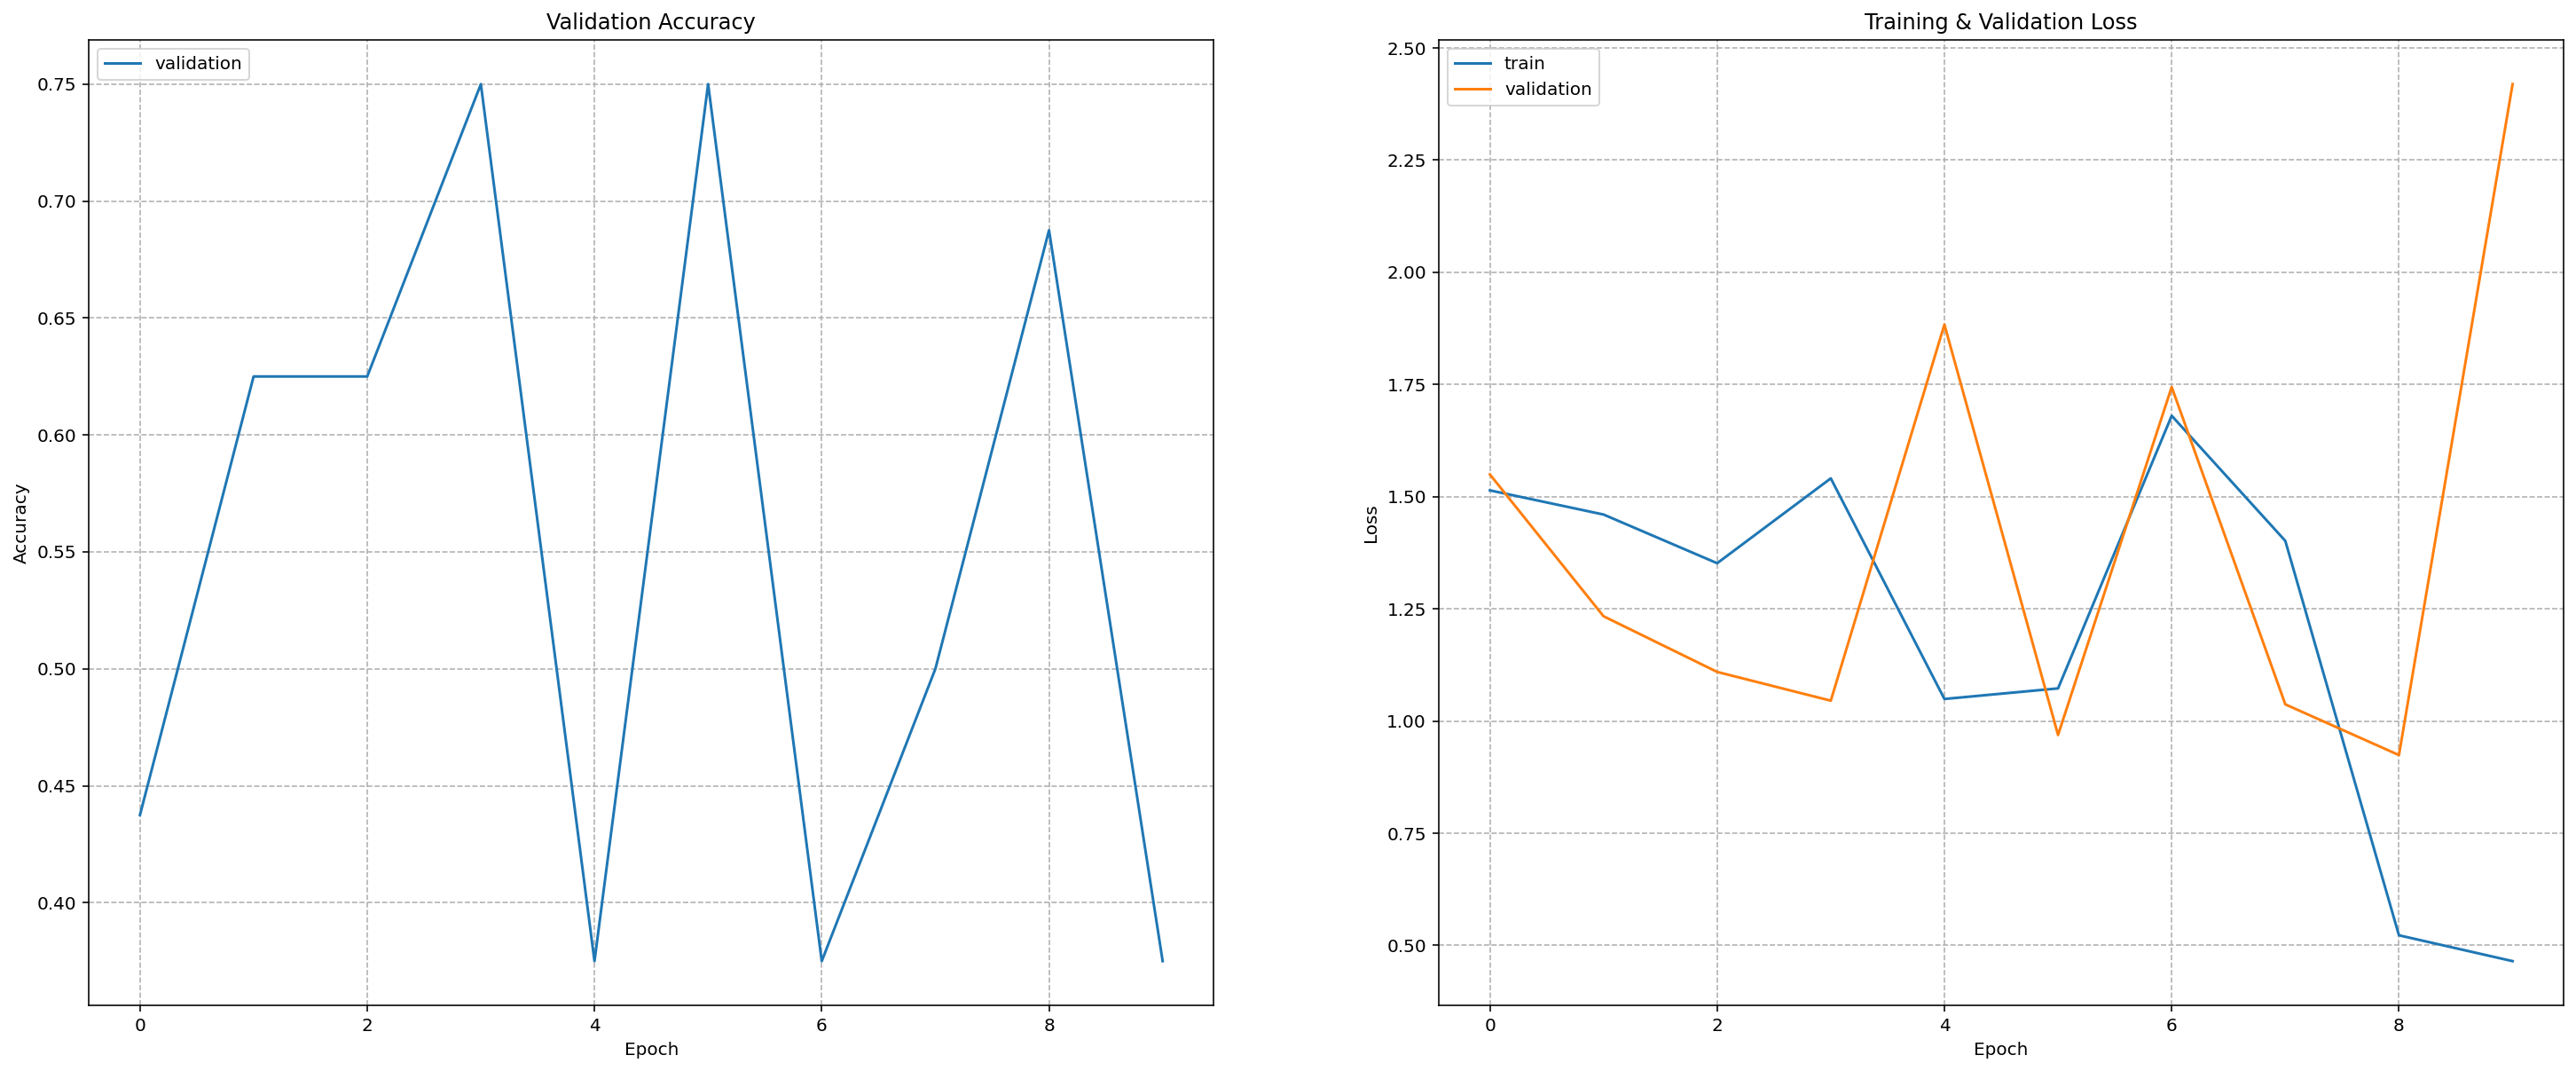

In [20]:
history = history3
"""Show accuracy and loss graphs for train and test sets."""
train_loss = [x['loss'] for x in history]
val_loss = [x['val_loss'] for x in history]
val_acc = [x['val_acc'] for x in history]
train_loss = [x.item() for x in train_loss]
val_loss = [x.item() for x in val_loss]
val_acc = [x.item() for x in val_acc]

plt.figure(figsize=(25,10))

plt.subplot(121)
plt.plot(val_acc)
plt.grid(linestyle='--')
plt.title('Validation Accuracy');
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['validation'], loc='upper left')

plt.subplot(122)
plt.plot(train_loss)
plt.plot(val_loss)
plt.grid(linestyle='--')
plt.title('Training & Validation Loss');
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig('net_results.png')
plt.show()